In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression


In [4]:
import pandas as pd

df = pd.read_csv("../data/raw/book_fest_raw.csv")
df.columns = df.columns.str.strip()
df.shape


(448, 20)

In [5]:
ml_cols = [
    "Age",
    "Gender",
    "What is your association with Fergusson College?",
    "Which city are you originally from?",
    "What is your profession?",
    "How often do you read books?",
    "Preferred reading format?",
    "How many books do you buy per year?",
    "Have you made any/are you planning to make any purchases at the Pune Book Festival?"
]

ml_df = df[ml_cols].copy()
ml_df.head()


,Age,Gender,What is your association with Fergusson College?,Which city are you originally from?,What is your profession?,How often do you read books?,Preferred reading format?,How many books do you buy per year?,Have you made any/are you planning to make any purchases at the Pune Book Festival?
0,23,Female,Alumni,Pune,Technology,Rarely,Physical books,3–5,Yes
1,23,Male,Student,Sambhajinagar,Student,Monthly,Physical books,0–2,No
2,24,Male,No association,Ratnagiri,Student,Weekly,Physical books,11–20,Yes
3,23,Male,Alumni,Buldhana,Botanist,Few times a week,Physical books,3–5,Yes
4,19,Male,No association,Pune/Goa (Velsão),Healthcare,Few times a week,Physical books,3–5,No


In [6]:
target_col = "Have you made any/are you planning to make any purchases at the Pune Book Festival?"

X = ml_df.drop(columns=[target_col])
y = ml_df[target_col]


In [7]:
y.value_counts()


Have you made any/are you planning to make any purchases at the Pune Book Festival?
Yes    347
No      79
Name: count, dtype: int64

In [8]:
X = X.fillna("Unknown")
y = y.fillna("No")


In [10]:
categorical_cols = X.columns.tolist()


In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

model = LogisticRegression(max_iter=1000)

pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", model)
    ]
)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline.fit(X_train, y_train)


,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          No       0.40      0.10      0.16        20
         Yes       0.79      0.96      0.86        70

    accuracy                           0.77        90
   macro avg       0.59      0.53      0.51        90
weighted avg       0.70      0.77      0.71        90



In [14]:
feature_names = pipeline.named_steps["preprocessing"] \
    .named_transformers_["cat"] \
    .get_feature_names_out()

coefficients = pipeline.named_steps["model"].coef_[0]

importance_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
}).sort_values(by="coefficient", ascending=False)

importance_df.head(10)


,feature,coefficient
144,What is your profession?_Academics,0.679078
48,Gender_Prefer not to say,0.606943
183,How many books do you buy per year?_20+,0.552207
49,What is your association with Fergusson Colleg...,0.528406
10,Age_20,0.526950
130,Which city are you originally from?_Shivaji na...,0.512324
2,Age_15,0.489156
32,Age_45,0.481447
106,Which city are you originally from?_Nanded,0.463311
17,Age_27,0.447497


In [15]:
import pandas as pd

feature_names = pipeline.named_steps["preprocessing"] \
    .named_transformers_["cat"] \
    .get_feature_names_out()

coefficients = pipeline.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
})

# Sort by absolute impact
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)


In [16]:
top_features = coef_df.head(15)
top_features


,feature,coefficient,abs_coef
170,What is your profession?_Unknown,-1.585016,1.585016
107,Which city are you originally from?_Nashik,-1.031018,1.031018
108,Which city are you originally from?_Nashik,-1.024113,1.024113
13,Age_23,-0.851432,0.851432
181,How many books do you buy per year?_0–2,-0.817903,0.817903
126,Which city are you originally from?_Sangli,-0.781596,0.781596
62,Which city are you originally from?_Aundh,-0.757631,0.757631
92,Which city are you originally from?_Ladakh,-0.732866,0.732866
34,Age_48,-0.711051,0.711051
136,Which city are you originally from?_Trivandrum,-0.688723,0.688723


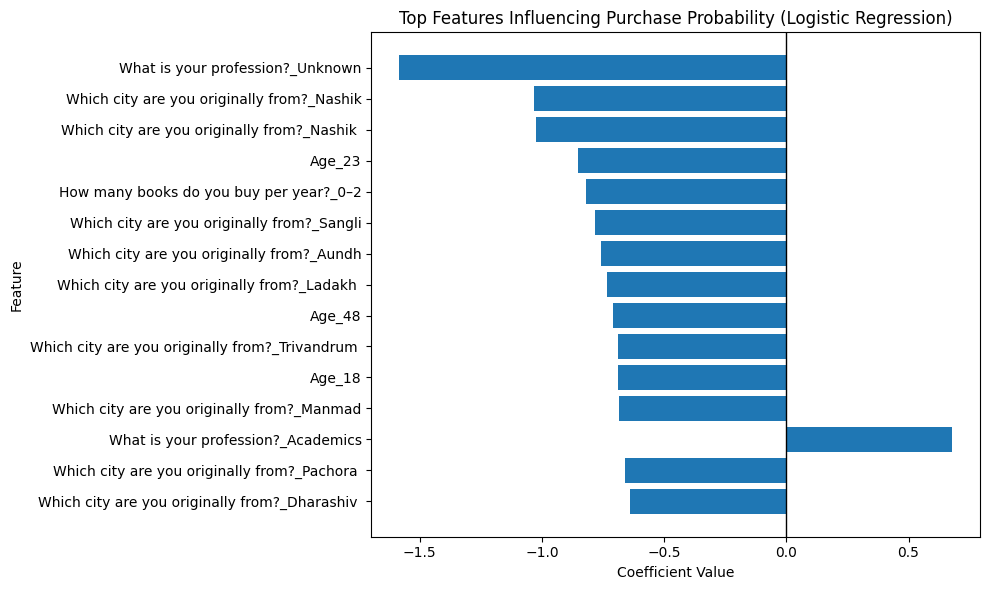

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(
    top_features["feature"],
    top_features["coefficient"]
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Top Features Influencing Purchase Probability (Logistic Regression)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [18]:
cluster_cols = [
    "Age",
    "Gender",
    "How often do you read books?",
    "Preferred reading format?",
    "Preferred book genres (select multiple)",
    "How many books do you buy per year?"
]

cluster_df = df[cluster_cols].copy()
cluster_df = cluster_df.fillna("Unknown")

cluster_df.head()


,Age,Gender,How often do you read books?,Preferred reading format?,Preferred book genres (select multiple),How many books do you buy per year?
0,23,Female,Rarely,Physical books,"Fiction, History",3–5
1,23,Male,Monthly,Physical books,Academic books,0–2
2,24,Male,Weekly,Physical books,"History, Biographies/Autobiographies, Academic...",11–20
3,23,Male,Few times a week,Physical books,"Fiction, Romance, Fantasy, Sci-Fi, Self-Help, ...",3–5
4,19,Male,Few times a week,Physical books,"Fiction, Romance, Fantasy, Self-Help, History,...",3–5


In [19]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_data = encoder.fit_transform(cluster_df)

encoded_data.shape


(448, 290)

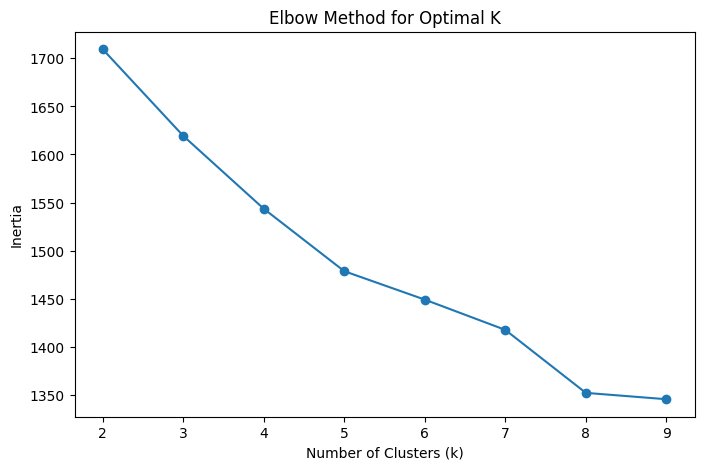

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(encoded_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker="o")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()


In [21]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(encoded_data)

cluster_df["Cluster"] = clusters
cluster_df.head()


,Age,Gender,How often do you read books?,Preferred reading format?,Preferred book genres (select multiple),How many books do you buy per year?,Cluster
0,23,Female,Rarely,Physical books,"Fiction, History",3–5,1
1,23,Male,Monthly,Physical books,Academic books,0–2,2
2,24,Male,Weekly,Physical books,"History, Biographies/Autobiographies, Academic...",11–20,2
3,23,Male,Few times a week,Physical books,"Fiction, Romance, Fantasy, Sci-Fi, Self-Help, ...",3–5,2
4,19,Male,Few times a week,Physical books,"Fiction, Romance, Fantasy, Self-Help, History,...",3–5,2


In [22]:
cluster_df["Cluster"].value_counts()



Cluster
1    190
2    164
0     94
Name: count, dtype: int64

In [23]:
cluster_summary = cluster_df.groupby("Cluster").agg({
    "Age": lambda x: x.value_counts().index[0],
    "How often do you read books?": lambda x: x.value_counts().index[0],
    "Preferred reading format?": lambda x: x.value_counts().index[0],
    "How many books do you buy per year?": lambda x: x.value_counts().index[0]
})

cluster_summary


,Age,How often do you read books?,Preferred reading format?,How many books do you buy per year?
Cluster,,,,
0,18,Rarely,E-books,0–2
1,18,Few times a week,Physical books,3–5
2,18,Few times a week,Physical books,3–5


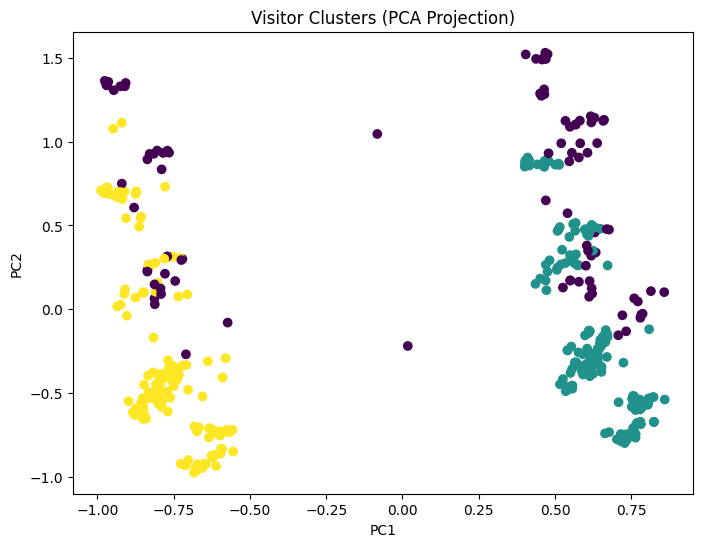

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_data)

plt.figure(figsize=(8,6))
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=clusters)
plt.title("Visitor Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
